# Generate datasets for integration

Here our aim is to use the RNAseq, Proteomics, and DNAmethylation datasets to identify different regulatory programs that change between conditions.


In [20]:
from sciutil import SciUtil
import pandas as pd
import os

base_dir = '../data/'
data_dir = f'{base_dir}raw_downloads/CPTAC/'
output_dir = f'{base_dir}sircle/F1_DE_input_TvN/'
fig_dir = '../figures/'
supp_dir = f'{base_dir}raw_downloads/supps/'
gene_name = 'hgnc_symbol'
save_fig = False

u = SciUtil()

## Load pre-generated datasets of all patients



In [21]:
rna_df = pd.read_csv(f'{output_dir}rna_df_sircle_ccRCC.csv')
rna_sample_df = pd.read_csv(f'{output_dir}rna_sample_df_sircle_ccRCC.csv',  index_col=0)

prot_sample_df = pd.read_csv(f'{output_dir}prot_sample_data_sircle_ccRCC.csv', index_col=0)
prot_df = pd.read_csv(f'{output_dir}prot_data_sircle_ccRCC.csv')

meth_df = pd.read_csv(f'{output_dir}meth_df_CPTAC-TCGA.csv') # Merged with TCGA columns as normal
clin_df = pd.read_csv(f'{output_dir}clinical_sircle.csv')
# Now we want to merge the clinical info with the cases from the sample df
meth_sample_df =  pd.read_csv(f'{output_dir}meth_sample_df_CPTAC-TCGA.csv', index_col=0)


## Have a look at the demographics

In [22]:
prot_sample_df['RaceGrouped'].value_counts()

White       135
Slavonic     18
Asian        10
Hispanic      6
Name: RaceGrouped, dtype: int64

In [23]:
prot_sample_df['AgeGrouped'].value_counts()

old       111
middle     60
young      13
Name: AgeGrouped, dtype: int64

In [24]:
prot_sample_df['gender'].value_counts()

Male      141
Female     43
Name: gender, dtype: int64

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
palette = ['#483873', '#1BD8A6', '#B117B7', '#AAC7E2', '#FFC107', '#016957', '#9785C0',
     '#D09139', '#338A03', '#FF69A1', '#5930B1', '#FFE884', '#35B567', '#1E88E5',
     '#ACAD60', '#A2FFB4', '#B618F5', '#854A9C']
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3, 2)
sns.set(rc={'figure.figsize': (3, 2), 'font.family': 'sans-serif',
            'font.sans-serif': 'Arial', 'font.size': 9}, style='ticks')

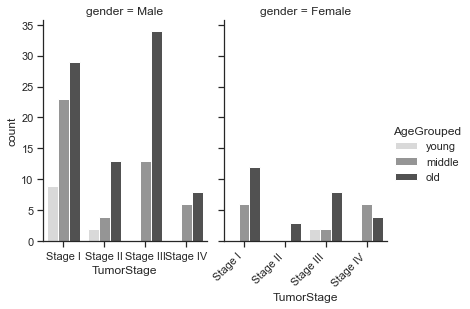

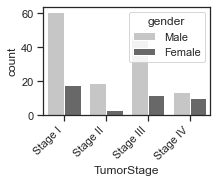

In [26]:
g = sns.catplot(x="TumorStage", hue="AgeGrouped", col="gender",
                order=['Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                data=prot_sample_df, kind="count", palette='Greys', hue_order=['young', 'middle', 'old'],
                height=4, aspect=.7)
plt.xticks(rotation=45, ha='right')
if save_fig:
    plt.savefig(f'{fig_dir}patient_demographics_age.svg')

plt.show()

# Also look at the gender
g = sns.countplot(x="TumorStage", hue="gender",
                order=['Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                data=prot_sample_df, palette='Greys')
plt.xticks(rotation=45, ha='right')
if save_fig:
    plt.savefig(f'{fig_dir}patient_demographics.svg')

In [27]:
rna_sample_df['AgeGrouped'].value_counts()

old       139
middle     85
young      15
Name: AgeGrouped, dtype: int64

In [28]:
rna_sample_df['TumorStage'].value_counts()

Stage I      99
Stage III    74
Stage IV     37
Stage II     29
Name: TumorStage, dtype: int64

## Code for plotting the separation of patients

In [29]:
# Have a look at clustering each of these
from sklearn.decomposition import PCA

def do_plts(df, sample_df, title, fig_dir, value="CPT"):
    cases = [c for c in df.columns if value in c]
    corr = df[cases].corr()
    row_colors_t = [[], [], [], []]
    ages = sample_df['AgeGrouped'].values
    genders = sample_df['gender'].values
    #cimps = sample_df['CIMPStatus'].values
    for i, c in enumerate(sample_df['CondId'].values):
        if c == 1:
            row_colors_t[0].append('red')
        else:
            row_colors_t[0].append('blue')
        if ages[i] == 'middle':
            row_colors_t[1].append('grey')
        elif ages[i] == 'old':
            row_colors_t[1].append('black') 
        else:
            row_colors_t[1].append('lightgrey') 
            
        if genders[i] == 'Male':
            row_colors_t[2].append('green')
        else:
            row_colors_t[2].append('yellow') 
        row_colors_t[3].append('pink')
    sns.clustermap(corr, 
                    xticklabels=sample_df['FullLabel'].values, figsize=(12, 20),
                    yticklabels=sample_df['FullLabel'].values, cmap='RdBu_r', row_cluster=True, 
                    col_cluster=True, row_colors=row_colors_t)
    plt.title(title)
    if save_fig:
        plt.savefig(os.path.join(fig_dir, f'Heatmap_{title}.svg'))
    plt.show()

    vals = df[cases].values.T
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_

    """
    ---------------------------------------------------------------
                Plot PCA
    ---------------------------------------------------------------
    """
    plt.rcParams['figure.figsize'] = [4, 4]

    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=row_colors_t[0], s=400, edgecolors=row_colors_t[2], linewidths=1.5)
    plt.scatter(pca_values[:, 0], pca_values[:, 1], c=row_colors_t[3], s=100, marker="X", edgecolors=row_colors_t[1], linewidths=1.5)

    plt.title(f'{title} PCA VAR: 0: {var_ratio[0]}, 1: {var_ratio[1]}')
    if save_fig:
        plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))

    # Now we want to fit everything except the gene IDs 
    plt.show()

## Generate datasets

## Save all tumour vs normal

RNA 66 173 239 239


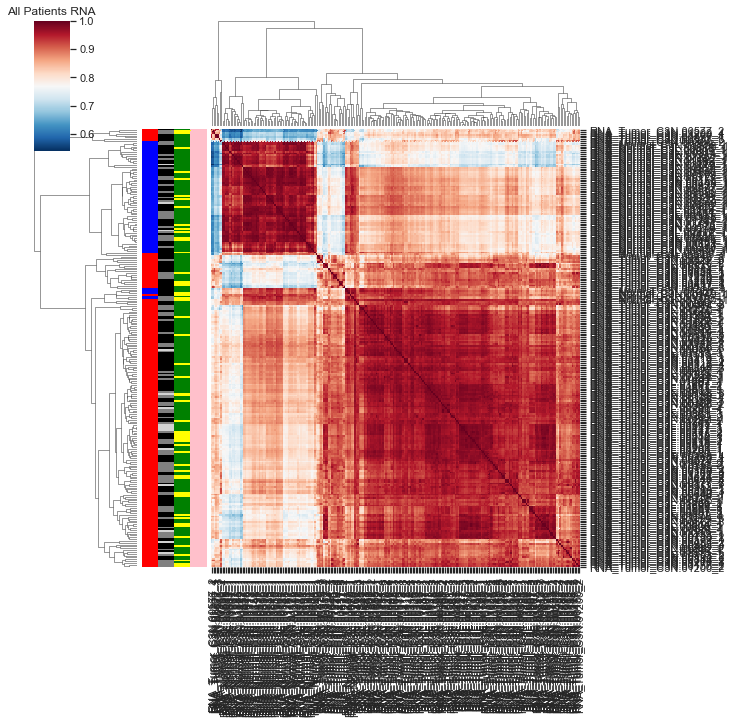

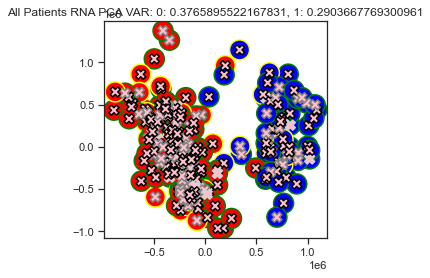

In [17]:
test_title = 'all_patients_ccRCC'

# RNA
meta_cols = [c for c in rna_df.columns if 'RNA' not in c and 'Unnamed' not in c]
normal_cases = [c.split('_')[2] for c in rna_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in rna_df.columns if 'Tumor' in c]
cases_matched = [c for c in tumour_cases] + [c for c in normal_cases] #[c for c in tumour_cases if c in normal_cases]
case_cols = [c for c in rna_df.columns if 'RNA' in c and c.split('_')[2] in cases_matched]
print("RNA", len(normal_cases), len(tumour_cases), len(cases_matched), len(case_cols))
sub_sample_df = rna_sample_df[rna_sample_df['FullLabel'].isin(case_cols)]
data_df = rna_df[meta_cols + list(rna_sample_df['FullLabel'].values)]
sub_sample_df.to_csv(os.path.join(output_dir, f'rna_sample_data_{test_title}_sircle.csv'))
data_df.to_csv(os.path.join(output_dir, f'rna_data_{test_title}_sircle.csv'), index=False)
do_plts(data_df, sub_sample_df, 'All Patients RNA', fig_dir, value="RNA")


Protein 81 103 184 184


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


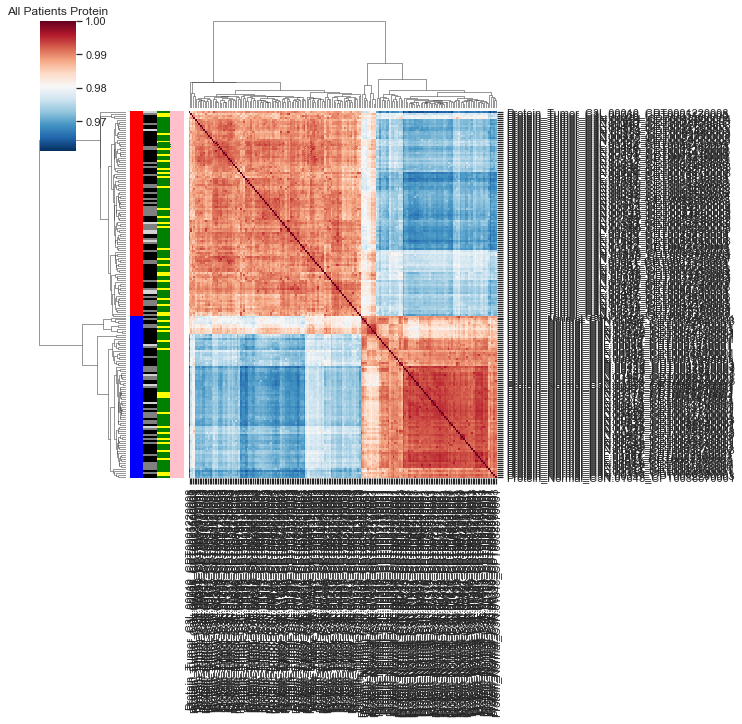

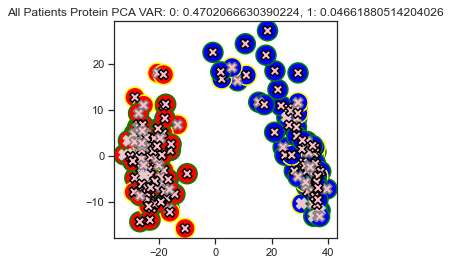

In [18]:
# Protein
meta_cols = [c for c in prot_df.columns if 'Protein' not in c]
case_cols = [c for c in prot_df.columns if 'Protein' in c]
normal_cases = [c.split('_')[2] for c in prot_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in prot_df.columns if 'Tumor' in c]
cases_matched = [c for c in tumour_cases] + [c for c in normal_cases] #[c for c in tumour_cases if c in normal_cases]
case_cols = [c for c in prot_df.columns if 'Protein' in c and c.split('_')[2] in cases_matched]
print("Protein", len(normal_cases), len(tumour_cases), len(cases_matched), len(case_cols))
sub_sample_df = prot_sample_df[prot_sample_df['FullLabel'].isin(case_cols)]
data_df = prot_df[meta_cols + list(prot_sample_df['FullLabel'].values)]
sub_sample_df.to_csv(os.path.join(output_dir, f'prot_sample_data_{test_title}_sircle.csv'))
data_df.to_csv(os.path.join(output_dir, f'prot_data_{test_title}_sircle.csv'), index=False)
do_plts(data_df, sub_sample_df, 'All Patients Protein', fig_dir, value="Protein")


METH 151 100 251 251


/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


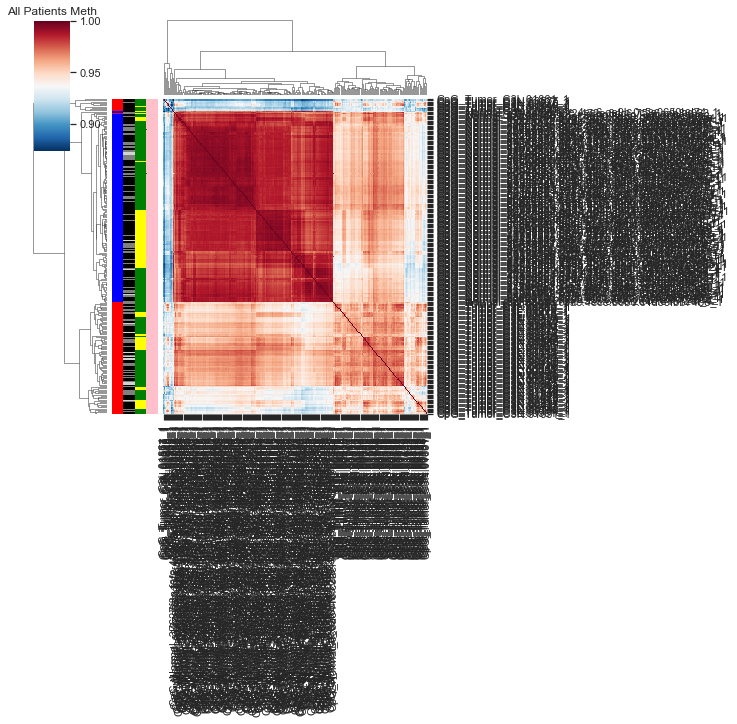

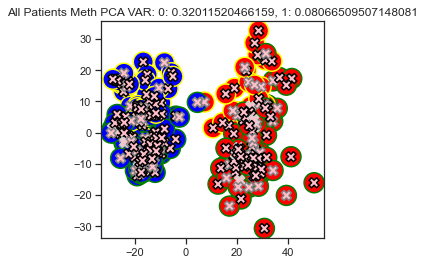

In [19]:
# Methylation
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]
case_cols = [c for c in meth_df.columns if 'CpG' in c]
sub_sample_df = meth_sample_df[meth_sample_df['FullLabel'].isin(case_cols)]
data_df = meth_df[meta_cols + list(sub_sample_df['FullLabel'].values)]
normal_cases = [c.split('_')[2] for c in meth_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_df.columns if 'Tumor' in c]
cases_matched =[c for c in tumour_cases] + [c for c in normal_cases] # [c for c in tumour_cases if c in normal_cases]
print("METH", len(normal_cases), len(tumour_cases), len(cases_matched), len(case_cols))
sub_sample_df.to_csv(os.path.join(output_dir, f'cpg_sample_data_{test_title}_sircle.csv'))
data_df.to_csv(os.path.join(output_dir, f'cpg_data_{test_title}_sircle.csv'), index=False)
do_plts(data_df, sub_sample_df, 'All Patients Meth', fig_dir, value="CpG")



## Make a subset of Stage IV vs Stage 1 patients

RNA 12 25


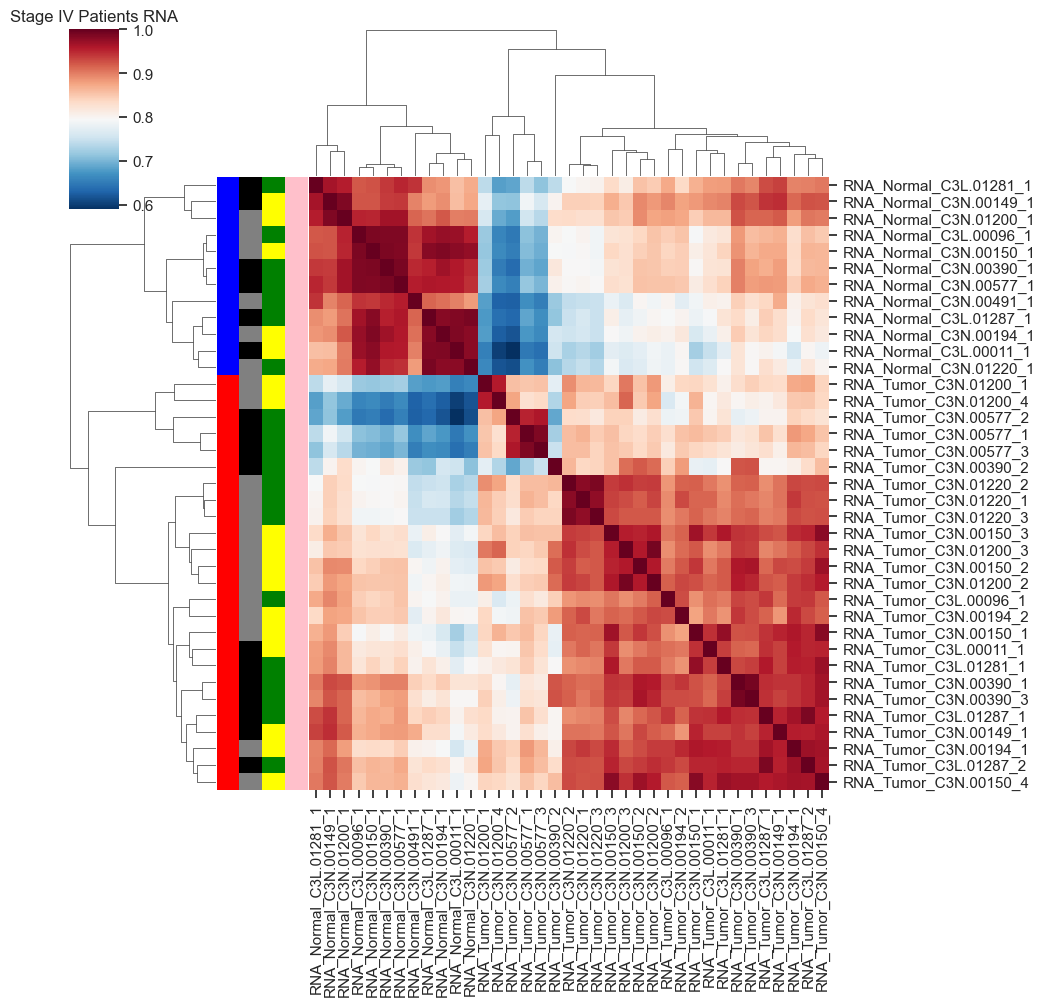

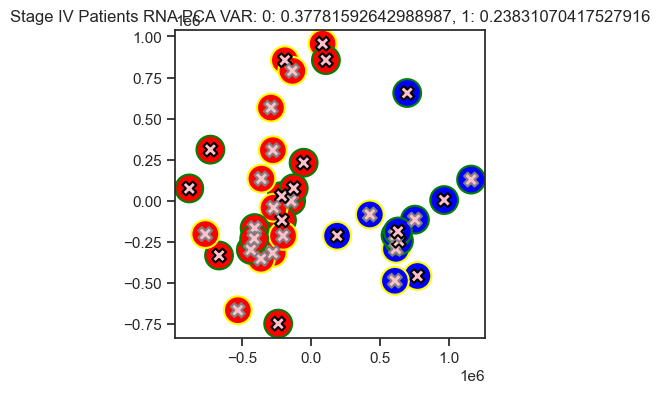

Protein 12 12


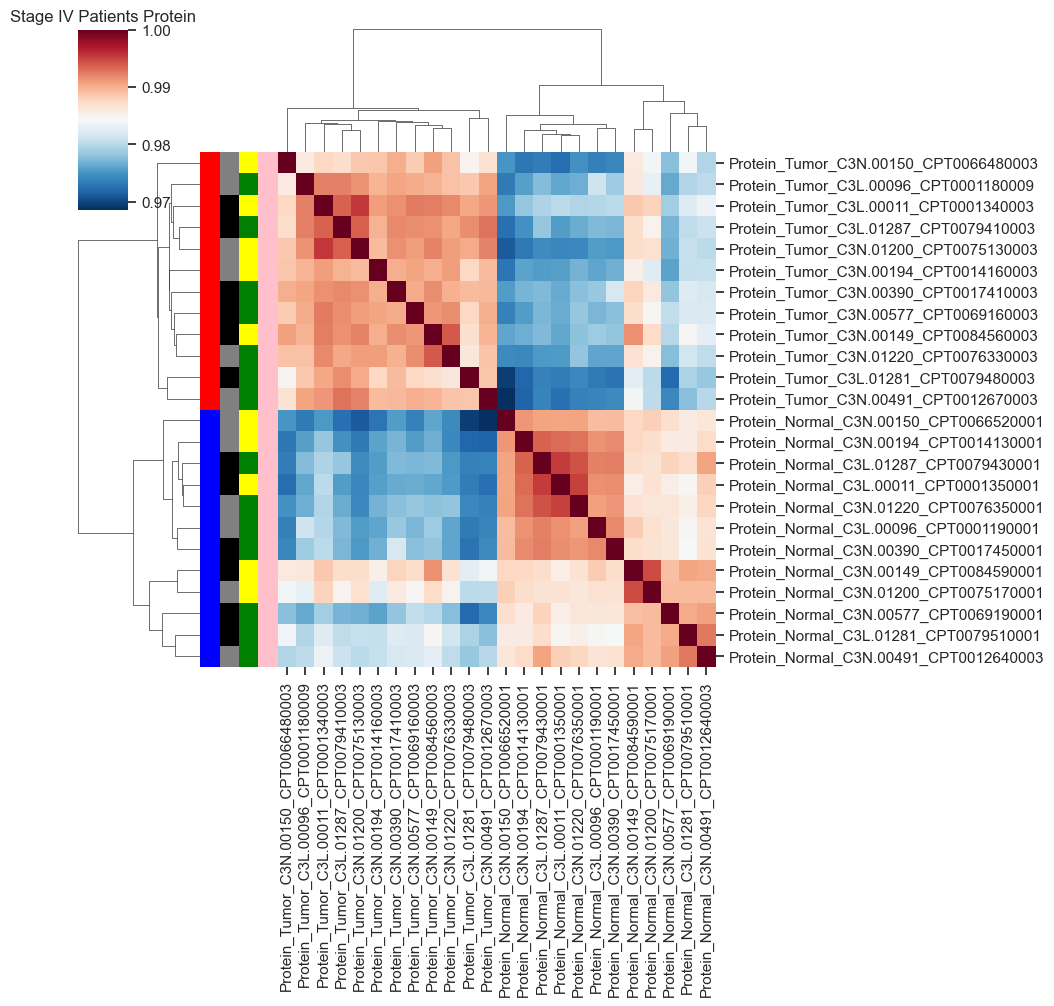

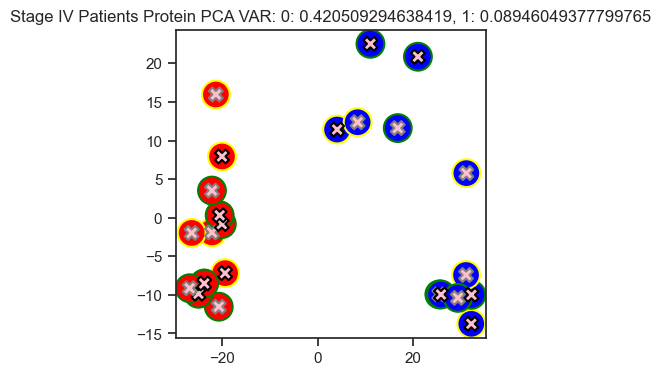

Methylation 33 11


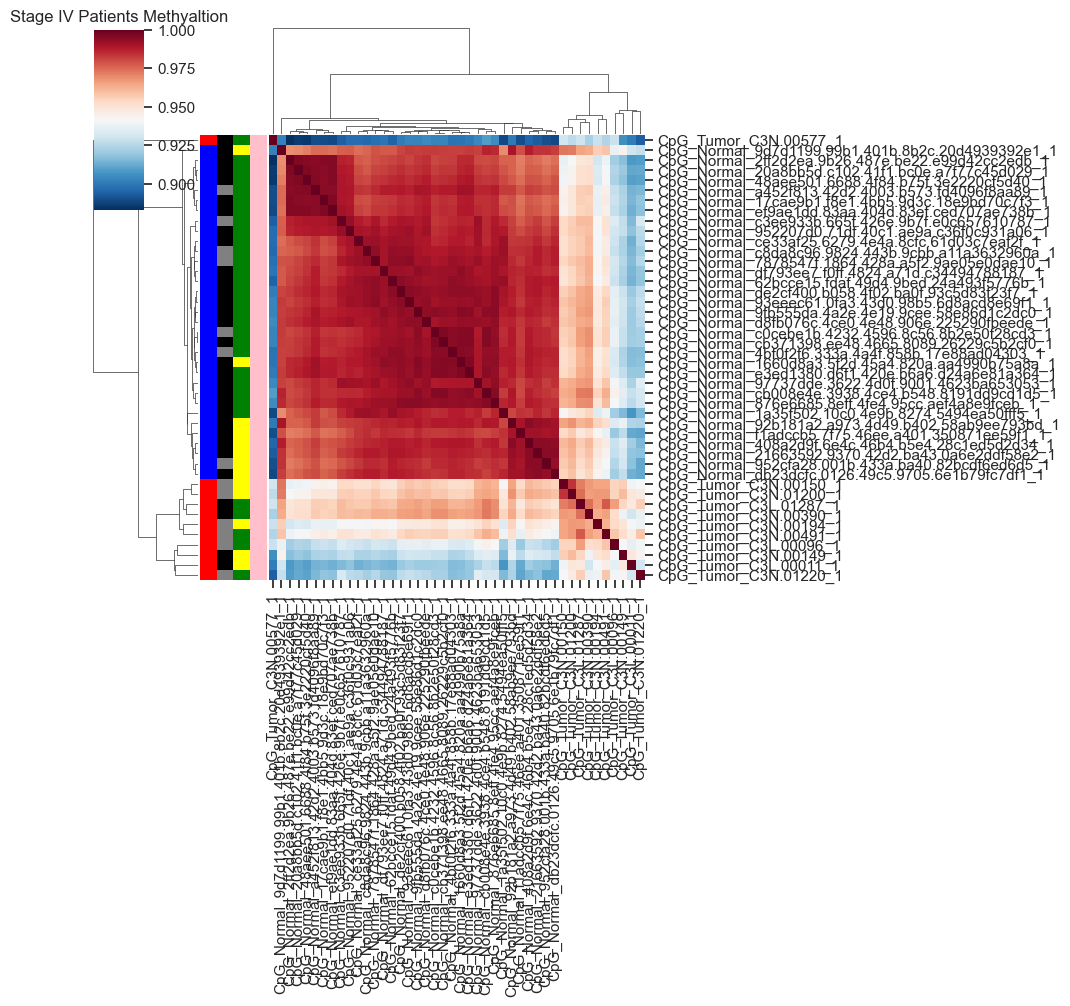

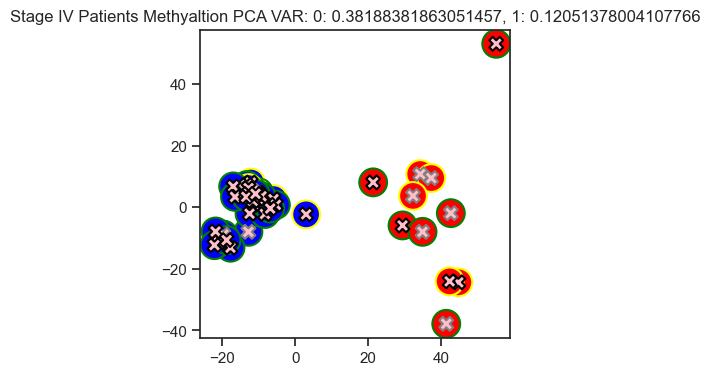

In [15]:
test_title = 'Stage IV'

# RNA
meta_cols = [c for c in rna_df.columns if 'RNA' not in c and 'Unnamed' not in c]

rna_sub_sample_df = rna_sample_df[rna_sample_df['TumorStage'] == test_title]
rna_data_df = rna_df[meta_cols + list(rna_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in rna_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in rna_data_df.columns if 'Tumor' in c]
print("RNA", len(normal_cases), len(tumour_cases))

rna_sub_sample_df.to_csv(os.path.join(output_dir, f'rna_sample_data_{test_title}_sircle.csv'))
rna_data_df.to_csv(os.path.join(output_dir, f'rna_data_{test_title}_sircle.csv'), index=False)
do_plts(rna_data_df, rna_sub_sample_df, f'{test_title} Patients RNA', fig_dir, value="RNA")

# Protein
meta_cols = [c for c in prot_df.columns if 'Protein' not in c]

prot_sub_sample_df = prot_sample_df[prot_sample_df['TumorStage'] == test_title]
prot_data_df = prot_df[meta_cols + list(prot_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in prot_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in prot_data_df.columns if 'Tumor' in c]

print("Protein", len(normal_cases), len(tumour_cases))
prot_sub_sample_df.to_csv(os.path.join(output_dir, f'prot_sample_data_{test_title}_sircle.csv'))
prot_data_df.to_csv(os.path.join(output_dir, f'prot_data_{test_title}_sircle.csv'), index=False)
do_plts(prot_data_df, prot_sub_sample_df, f'{test_title} Patients Protein', fig_dir, value="Protein")

# Methylation
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]

meth_sub_sample_df = meth_sample_df[meth_sample_df['TumorStage'] == test_title]
# Based on the clustering, we had one outlier sample which we will remove for the DE analysus
columns = [c for c in list(meth_sub_sample_df['FullLabel'].values)]
meth_data_df = meth_df[meta_cols + columns]

normal_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Tumor' in c]

print("Methylation", len(normal_cases), len(tumour_cases))
meth_sub_sample_df.to_csv(os.path.join(output_dir, f'meth_sample_data_{test_title}_sircle.csv'))
meth_data_df.to_csv(os.path.join(output_dir, f'meth_data_{test_title}_sircle.csv'), index=False)
do_plts(meth_data_df, meth_sub_sample_df, f'{test_title} Patients Methyaltion', fig_dir, value="CpG")


Methylation 33 10


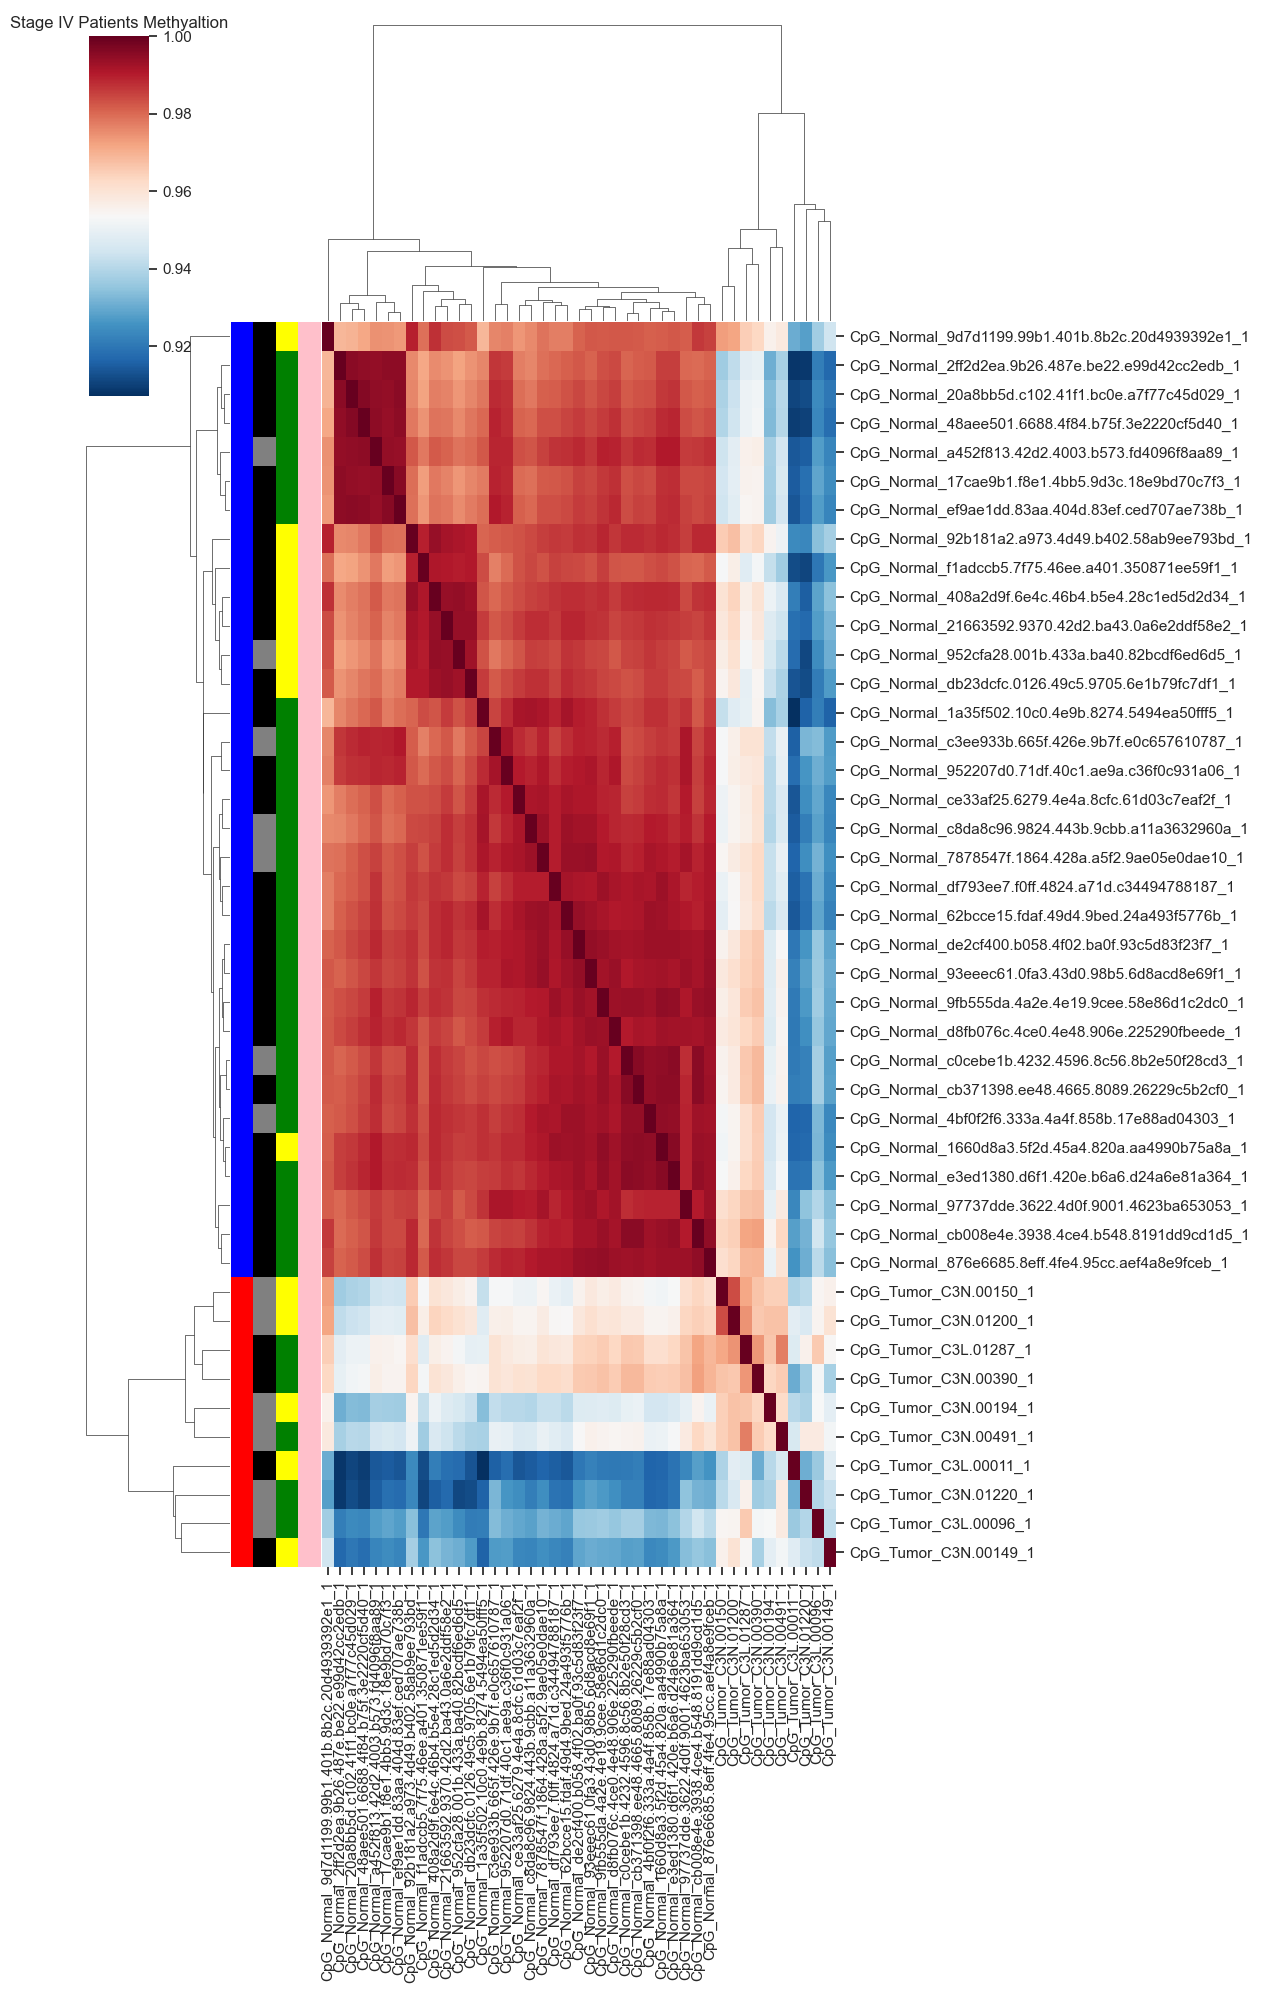

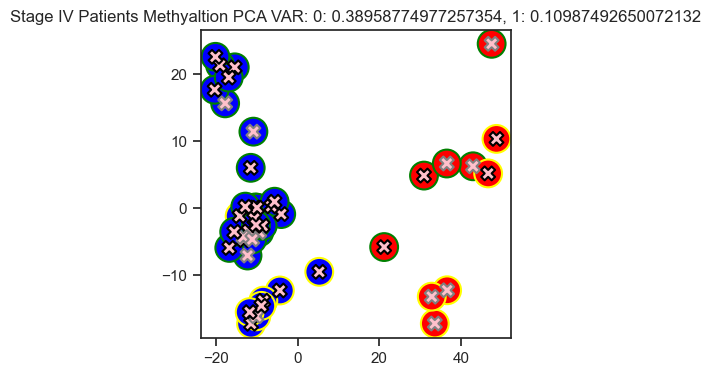

In [26]:
test_title = 'Stage IV'

# Redo Methylation to remove the outlier patient
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]

meth_sub_sample_df = meth_sample_df[meth_sample_df['TumorStage'] == test_title]
# Based on the clustering, we had one outlier sample which we will remove for the DE analysus
columns = [c for c in list(meth_sub_sample_df['FullLabel'].values) if c != 'CpG_Tumor_C3N.00577_1']
meth_sub_sample_df = meth_sub_sample_df[meth_sub_sample_df['FullLabel'].isin(columns)]
meth_data_df = meth_df[meta_cols + columns]

normal_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Tumor' in c]

print("Methylation", len(normal_cases), len(tumour_cases))
meth_sub_sample_df.to_csv(os.path.join(output_dir, f'cpg_sample_data_{test_title}_sircle.csv'))
meth_data_df.to_csv(os.path.join(output_dir, f'cpg_data_{test_title}_sircle.csv'), index=False)
do_plts(meth_data_df, meth_sub_sample_df, f'{test_title} Patients Methyaltion', fig_dir, value="CpG")

RNA 24 75


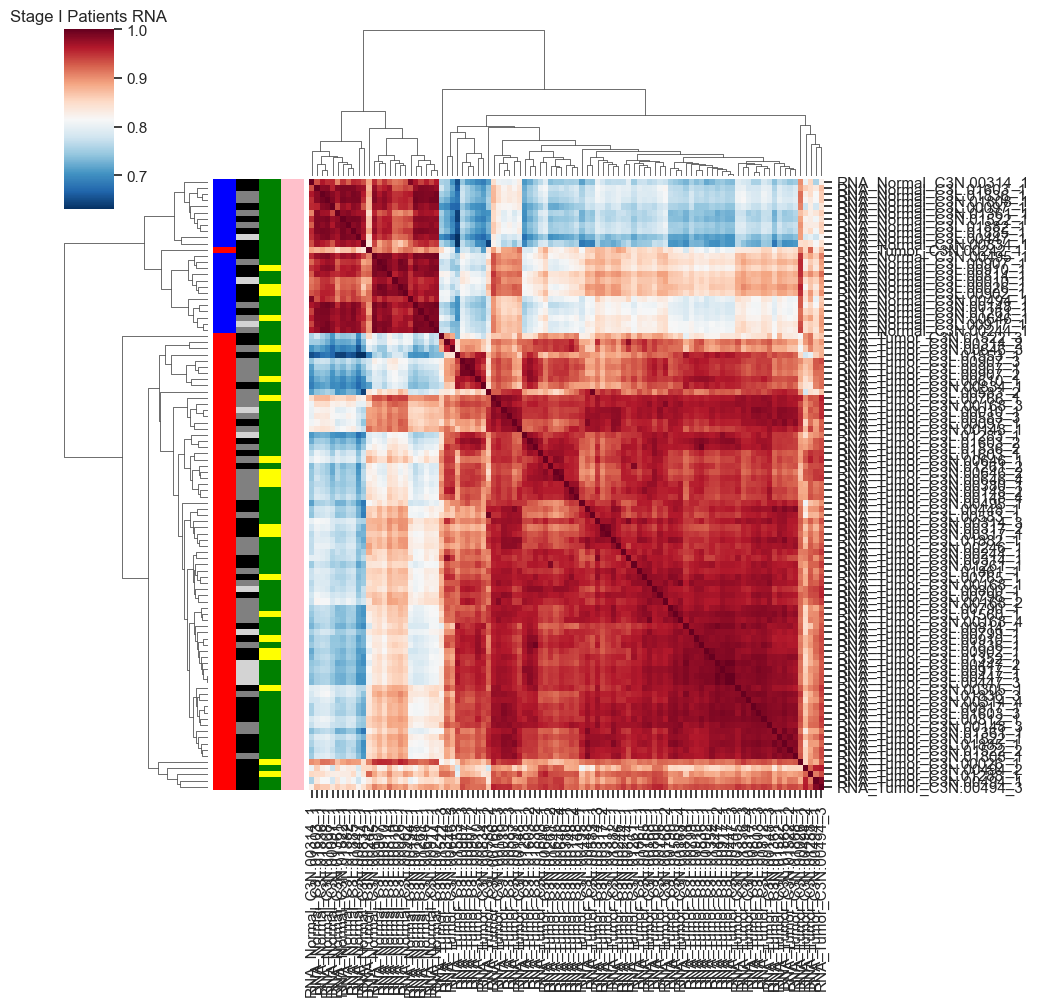

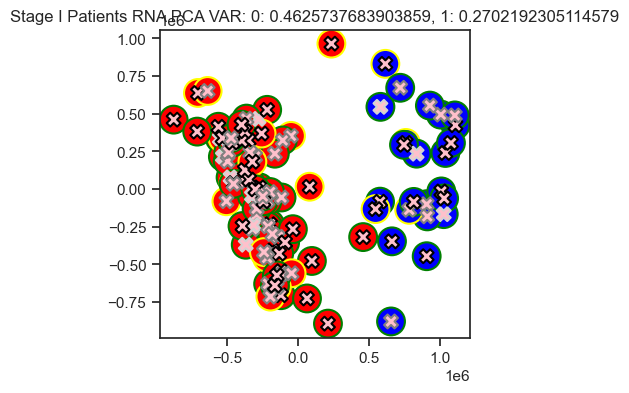

Protein 31 48


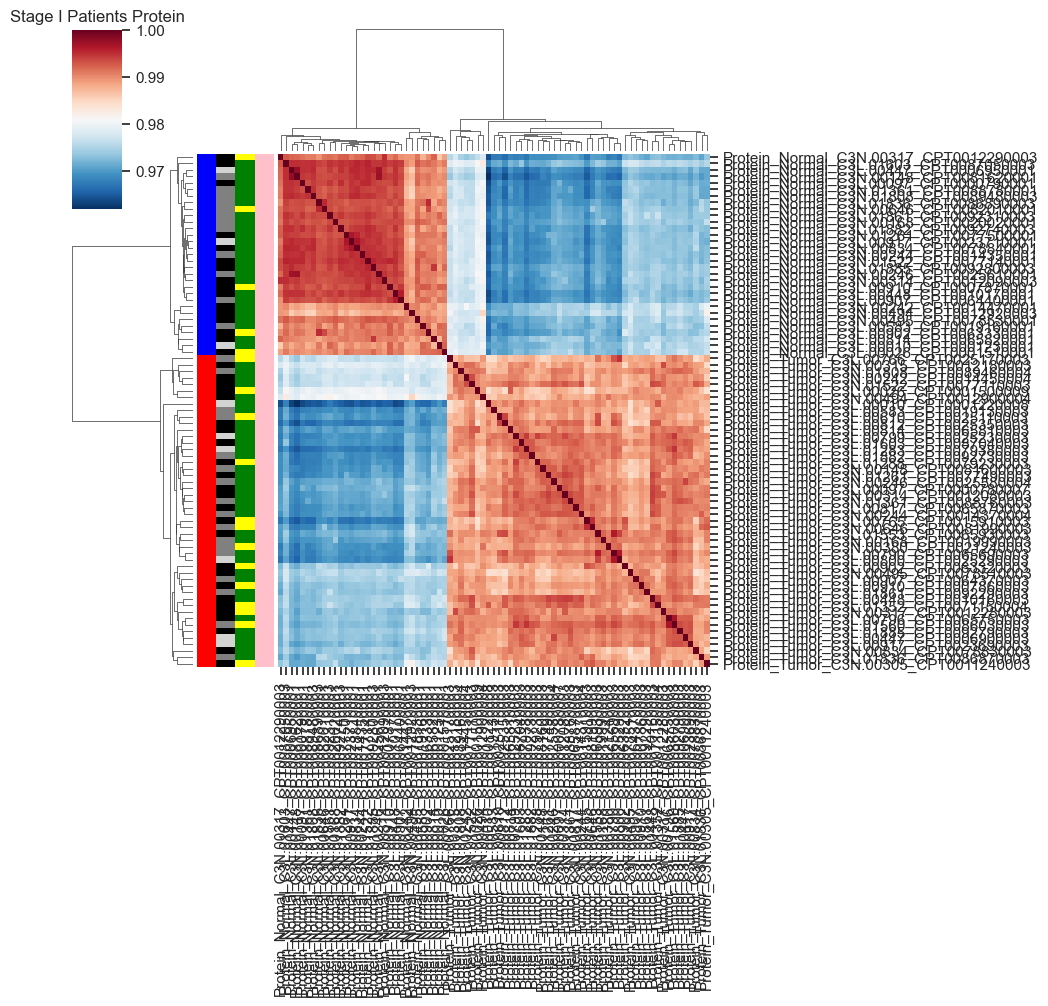

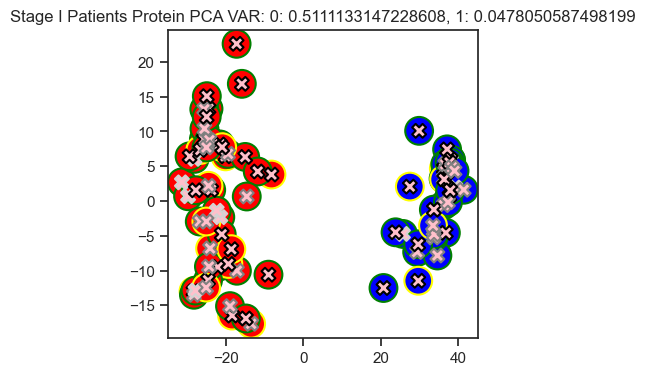

Methylation 54 46


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


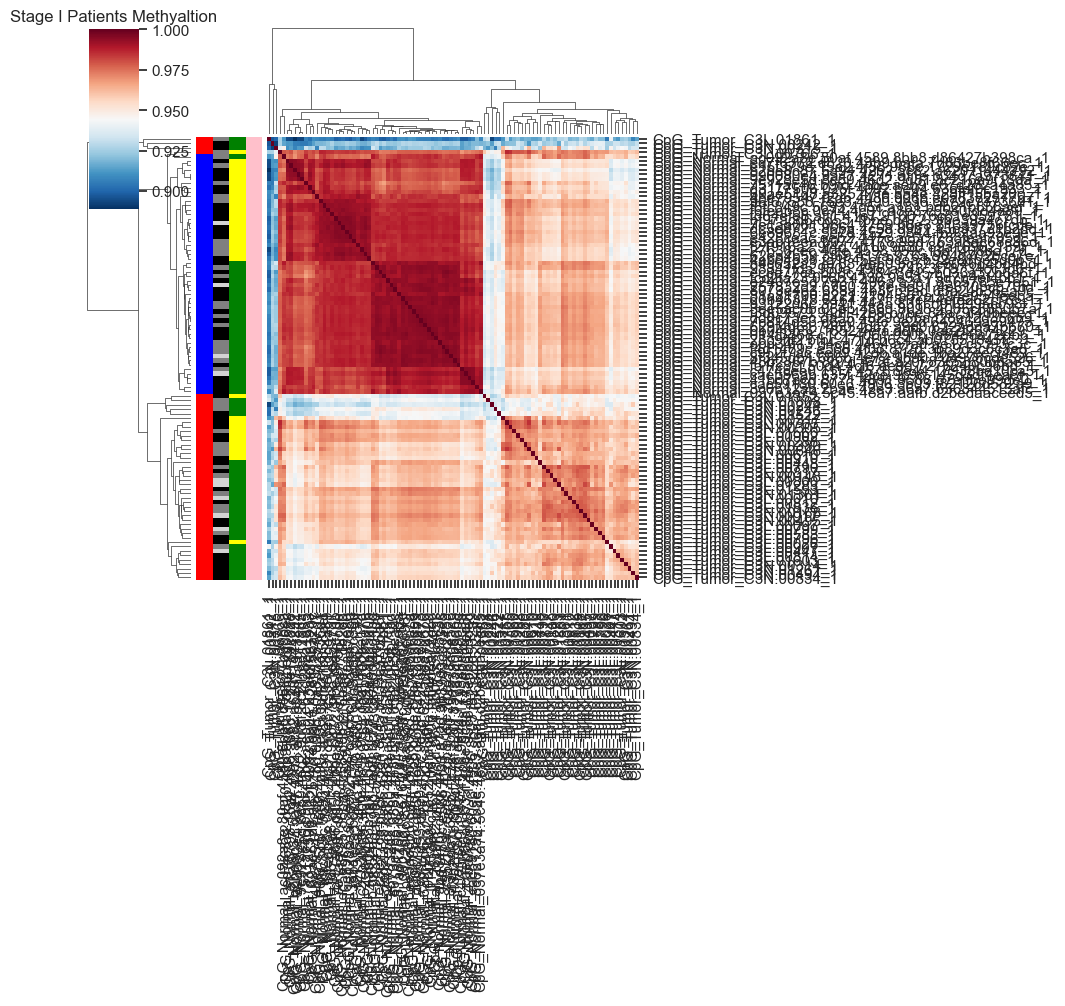

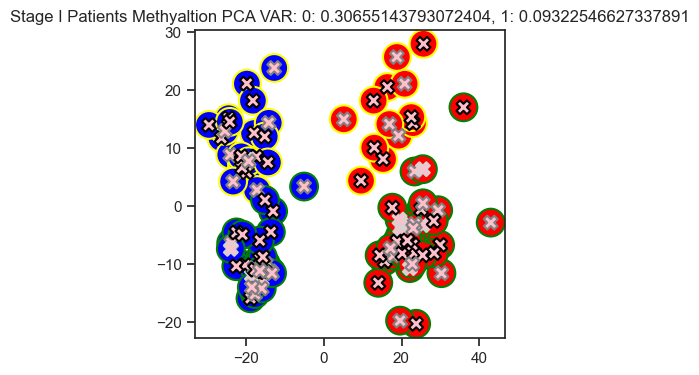

In [14]:
test_title = 'Stage I'

# RNA
meta_cols = [c for c in rna_df.columns if 'RNA' not in c and 'Unnamed' not in c]

rna_sub_sample_df = rna_sample_df[rna_sample_df['TumorStage'] == test_title]
rna_data_df = rna_df[meta_cols + list(rna_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in rna_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in rna_data_df.columns if 'Tumor' in c]
print("RNA", len(normal_cases), len(tumour_cases))

rna_sub_sample_df.to_csv(os.path.join(output_dir, f'rna_sample_data_{test_title}_sircle.csv'))
rna_data_df.to_csv(os.path.join(output_dir, f'rna_data_{test_title}_sircle.csv'), index=False)
do_plts(rna_data_df, rna_sub_sample_df, f'{test_title} Patients RNA', fig_dir, value="RNA")

# Protein
meta_cols = [c for c in prot_df.columns if 'Protein' not in c]

prot_sub_sample_df = prot_sample_df[prot_sample_df['TumorStage'] == test_title]
prot_data_df = prot_df[meta_cols + list(prot_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in prot_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in prot_data_df.columns if 'Tumor' in c]

print("Protein", len(normal_cases), len(tumour_cases))
prot_sub_sample_df.to_csv(os.path.join(output_dir, f'prot_sample_data_{test_title}_sircle.csv'))
prot_data_df.to_csv(os.path.join(output_dir, f'prot_data_{test_title}_sircle.csv'), index=False)
do_plts(prot_data_df, prot_sub_sample_df, f'{test_title} Patients Protein', fig_dir, value="Protein")

# Methylation
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]

meth_sub_sample_df = meth_sample_df[meth_sample_df['TumorStage'] == test_title]
meth_data_df = meth_df[meta_cols + list(meth_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Tumor' in c]

print("Methylation", len(normal_cases), len(tumour_cases))
meth_sub_sample_df.to_csv(os.path.join(output_dir, f'meth_sample_data_{test_title}_sircle.csv'))
meth_data_df.to_csv(os.path.join(output_dir, f'meth_data_{test_title}_sircle.csv'), index=False)
do_plts(meth_data_df, meth_sub_sample_df, f'{test_title} Patients Methyaltion', fig_dir, value="CpG")


Methylation 54 42


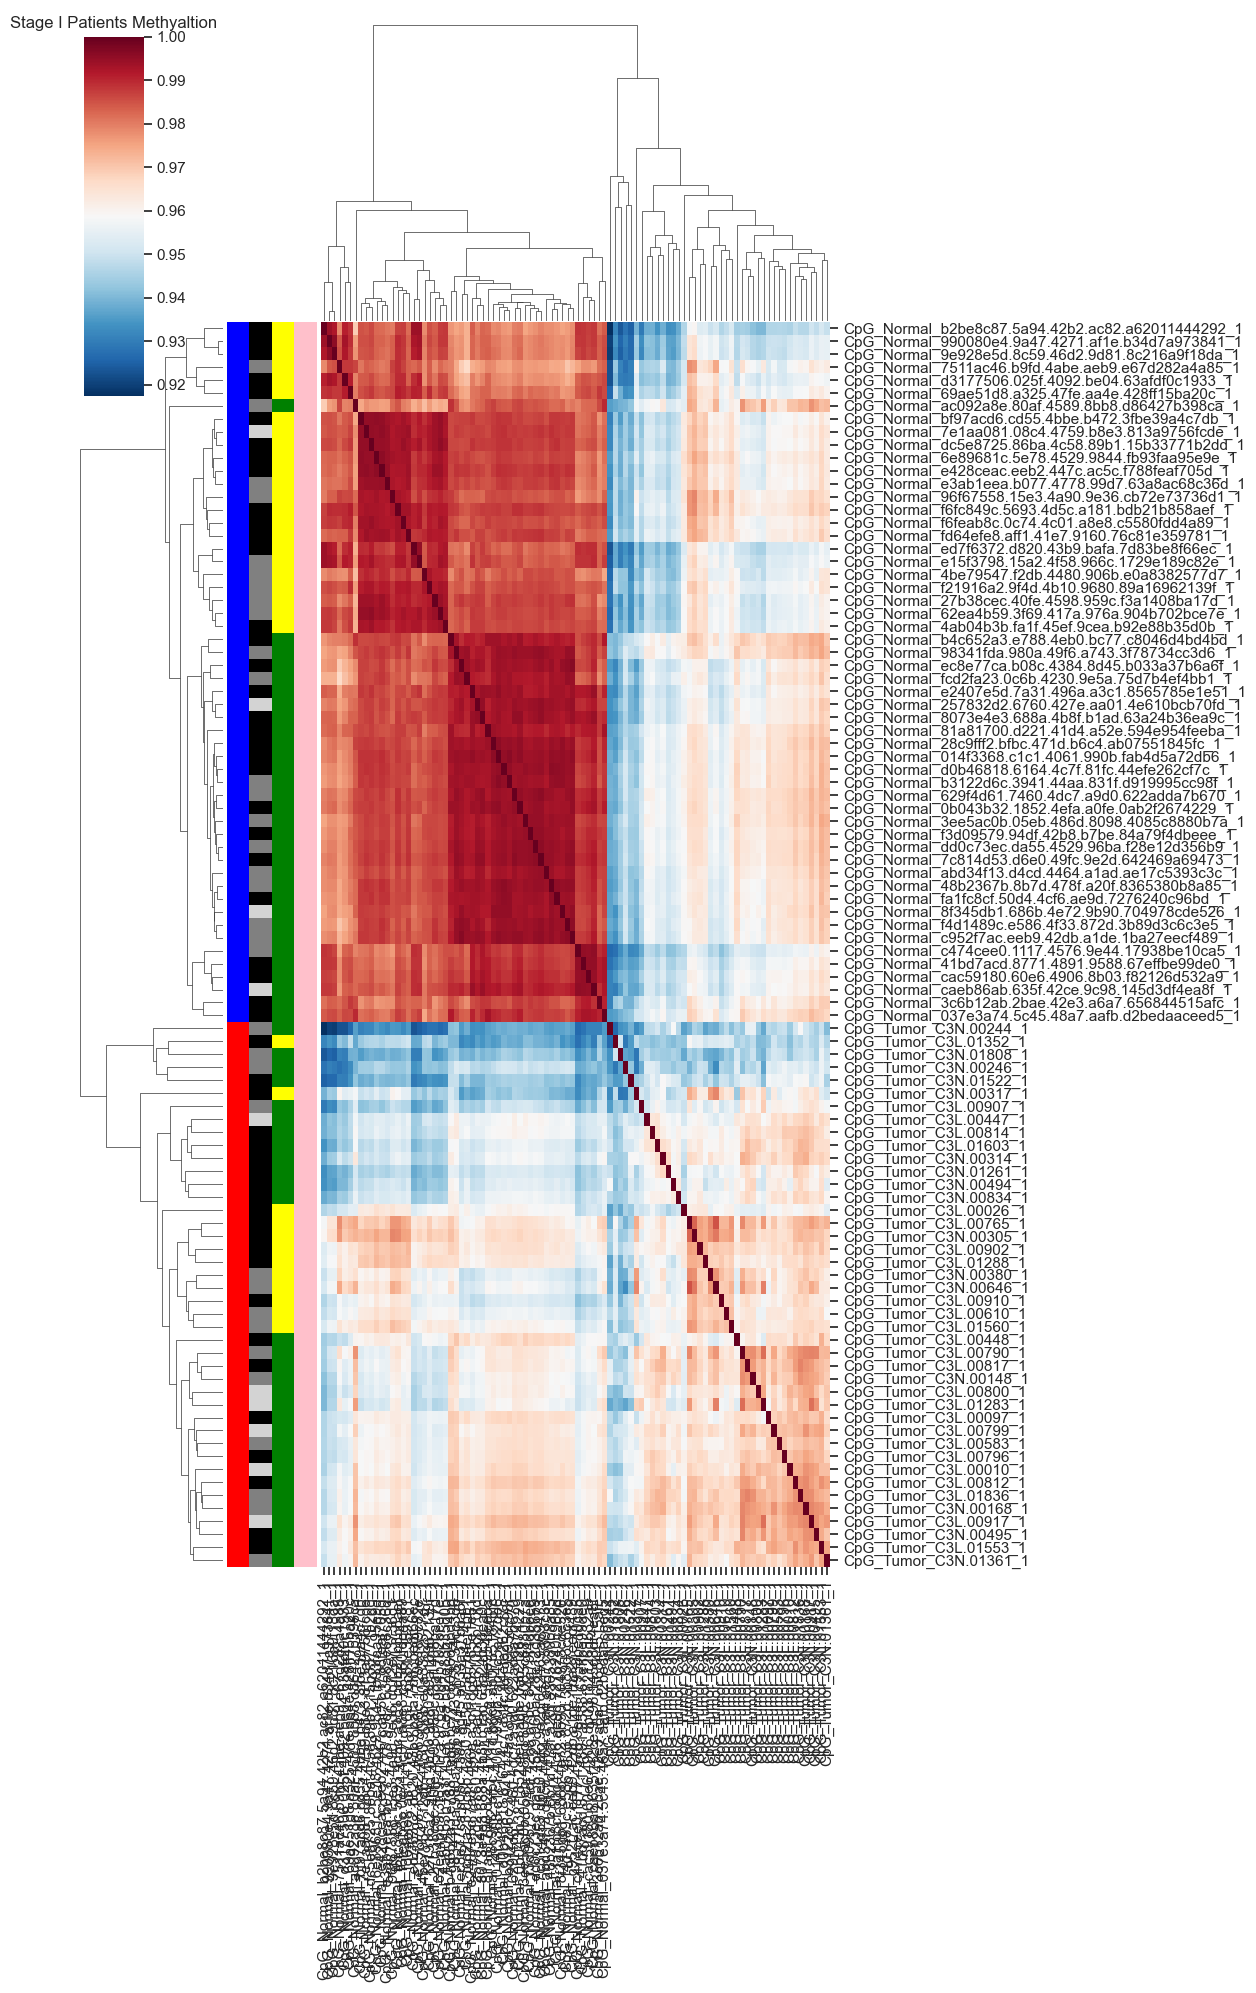

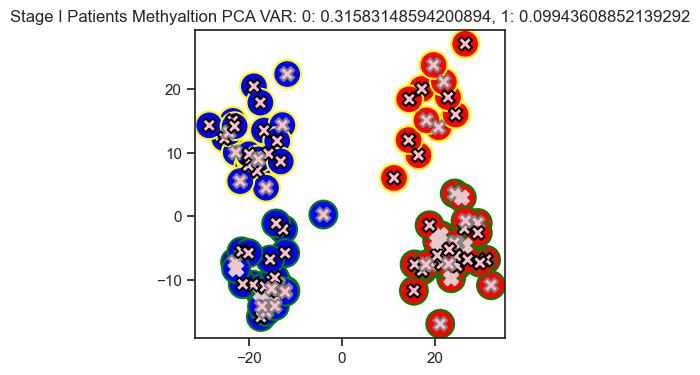

In [24]:
test_title = 'Stage I'

# Redo Methylation to remove the outlier patients
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]

meth_sub_sample_df = meth_sample_df[meth_sample_df['TumorStage'] == test_title]
meth_data_df = meth_df[meta_cols + list(meth_sub_sample_df['FullLabel'].values)]

# Based on the clustering, we had one outlier sample which we will remove for the DE analysus
columns = [c for c in list(meth_sub_sample_df['FullLabel'].values) if c not in 
           ['CpG_Tumor_C3L.01861_1', 'CpG_Tumor_C3N.00242_1', 'CpG_Tumor_C3N.00315_1', 'CpG_Tumor_C3L.00766_1']]
meth_sub_sample_df = meth_sub_sample_df[meth_sub_sample_df['FullLabel'].isin(columns)]
meth_data_df = meth_df[meta_cols + columns]
normal_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Tumor' in c]

print("Methylation", len(normal_cases), len(tumour_cases))
meth_sub_sample_df.to_csv(os.path.join(output_dir, f'cpg_sample_data_{test_title}_sircle.csv'))
meth_data_df.to_csv(os.path.join(output_dir, f'cpg_data_{test_title}_sircle.csv'), index=False)
do_plts(meth_data_df, meth_sub_sample_df, f'{test_title} Patients Methyaltion', fig_dir, value="CpG")


In [31]:
meth_sample_df

SampleId  \
case                                                                                
C3L-00004                                                         C3L-00004_Tumor   
C3L-00010                                                         C3L-00010_Tumor   
C3L-00011                                                         C3L-00011_Tumor   
C3L-00026                                                         C3L-00026_Tumor   
C3L-00079                                                         C3L-00079_Tumor   
...                                                                           ...   
f29b6c8c-d713-42ad-9b90-e556df9b05cd  f29b6c8c-d713-42ad-9b90-e556df9b05cd_Normal   
cb371398-ee48-4665-8089-26229c5b2cf0  cb371398-ee48-4665-8089-26229c5b2cf0_Normal   
ac092a8e-80af-4589-8bb8-d86427b398ca  ac092a8e-80af-4589-8bb8-d86427b398ca_Normal   
318f6ffb-1fdf-4f74-90db-21e337503aae  318f6ffb-1fdf-4f74-90db-21e337503aae_Normal   
ef9ae1dd-83aa-404d-83ef-ced707ae738b  ef9ae1dd-83aa-404d-83ef-ced707ae738b_Normal   

                                      CondId CondName  \
case                                                    
C3L-00004                                  1    Tumor   
C3L-00010                                  1    Tumor   
C3L-00011                                  1    Tumor   
C3L-00026                                  1    Tumor   
C3L-00079                                  1    Tumor   
...                                      ...      ...   
f29b6c8c-d713-42ad-9b90-e556df9b05cd       0   Normal   
cb371398-ee48-4665-8089-26229c5b2cf0       0   Normal   
ac092a8e-80af-4589-8bb8-d86427b398ca       0   Normal   
318f6ffb-1fdf-4f74-90db-21e337503aae       0   Normal   
ef9ae1dd-83aa-404d-83ef-ced707ae738b       0   Normal   

                                                                 SafeCases  \
case                                                                         
C3L-00004                                                        C3L.00004   
C3L-00010                                                        C3L.00010   
C3L-00011                                                        C3L.00011   
C3L-00026                                                        C3L.00026   
C3L-00079                                                        C3L.00079   
...                                                                    ...   
f29b6c8c-d713-42ad-9b90-e556df9b05cd  f29b6c8c.d713.42ad.9b90.e556df9b05cd   
cb371398-ee48-4665-8089-26229c5b2cf0  cb371398.ee48.4665.8089.26229c5b2cf0   
ac092a8e-80af-4589-8bb8-d86427b398ca  ac092a8e.80af.4589.8bb8.d86427b398ca   
318f6ffb-1fdf-4f74-90db-21e337503aae  318f6ffb.1fdf.4f74.90db.21e337503aae   
ef9ae1dd-83aa-404d-83ef-ced707ae738b  ef9ae1dd.83aa.404d.83ef.ced707ae738b   

                                                                              FullLabel  \
case                                                                                      
C3L-00004                                                         CpG_Tumor_C3L.00004_1   
C3L-00010                                                         CpG_Tumor_C3L.00010_1   
C3L-00011                                                         CpG_Tumor_C3L.00011_1   
C3L-00026                                                         CpG_Tumor_C3L.00026_1   
C3L-00079                                                         CpG_Tumor_C3L.00079_1   
...                                                                                 ...   
f29b6c8c-d713-42ad-9b90-e556df9b05cd  CpG_Normal_f29b6c8c.d713.42ad.9b90.e556df9b05cd_1   
cb371398-ee48-4665-8089-26229c5b2cf0  CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1   
ac092a8e-80af-4589-8bb8-d86427b398ca  CpG_Normal_ac092a8e.80af.4589.8bb8.d86427b398ca_1   
318f6ffb-1fdf-4f74-90db-21e337503aae  CpG_Normal_318f6ffb.1fdf.4f74.90db.21e337503aae_1   
ef9ae1dd-83aa-404d-83ef-ced707ae738b  CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1   

                          

## Finally, to show the benefits of the VAE integration, show Stage I vs Stage IV tumours

Methylation 0 52


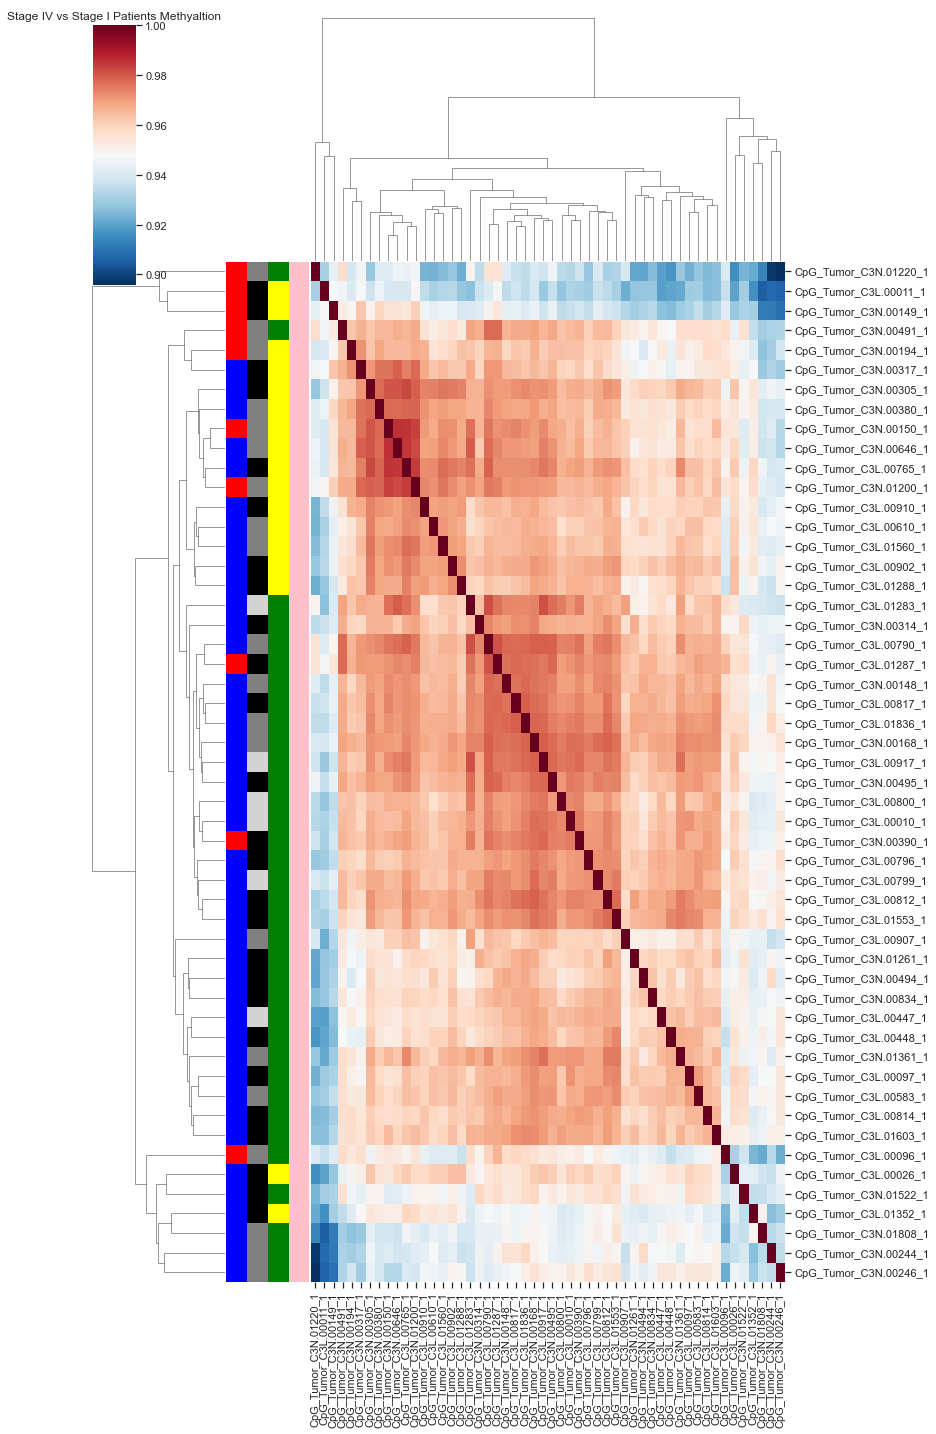

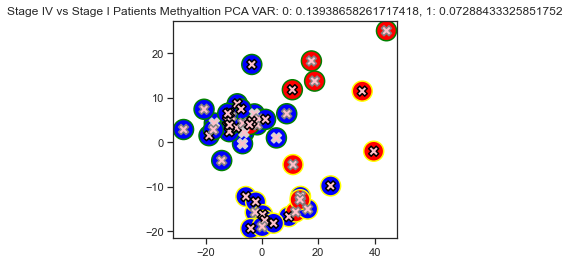

In [33]:
test_title = 'Stage IV vs Stage I'

# Redo Methylation to remove the outlier patients
meta_cols = [c for c in meth_df.columns if 'CpG' not in c]

meth_sub_sample_df = meth_sample_df[meth_sample_df['TumorStage'].isin(['Stage IV', 'Stage I'])]
# only include tumour samples
meth_sub_sample_df = meth_sub_sample_df[meth_sub_sample_df['CondId'] == 1]
# Updated condition ID to be 1 if stage IV and 0 if stage I
meth_sub_sample_df['CondId'] = [1 if s == 'Stage IV' else 0 for s in meth_sub_sample_df['TumorStage'].values]

meth_data_df = meth_df[meta_cols + list(meth_sub_sample_df['FullLabel'].values)]

# Based on the clustering, we had one outlier sample which we will remove for the DE analysus
columns = [c for c in list(meth_sub_sample_df['FullLabel'].values) if c not in 
           ['CpG_Tumor_C3L.01861_1', 'CpG_Tumor_C3N.00242_1', 'CpG_Tumor_C3N.00315_1', 'CpG_Tumor_C3L.00766_1', 'CpG_Tumor_C3N.00577_1']]
meth_sub_sample_df = meth_sub_sample_df[meth_sub_sample_df['FullLabel'].isin(columns)]
meth_data_df = meth_df[meta_cols + columns]
normal_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in meth_data_df.columns if 'Tumor' in c]

print("Methylation", len(normal_cases), len(tumour_cases))
meth_sub_sample_df.to_csv(os.path.join(output_dir, f'cpg_sample_data_{test_title}_sircle.csv'))
meth_data_df.to_csv(os.path.join(output_dir, f'cpg_data_{test_title}_sircle.csv'), index=False)
do_plts(meth_data_df, meth_sub_sample_df, f'{test_title} Patients Methyaltion', fig_dir, value="CpG")


In [42]:
meth_sub_sample_df

SampleId  CondId CondName  SafeCases              FullLabel  \
case                                                                            
C3L-00010  C3L-00010_Tumor       0    Tumor  C3L.00010  CpG_Tumor_C3L.00010_1   
C3L-00011  C3L-00011_Tumor       1    Tumor  C3L.00011  CpG_Tumor_C3L.00011_1   
C3L-00026  C3L-00026_Tumor       0    Tumor  C3L.00026  CpG_Tumor_C3L.00026_1   
C3L-00096  C3L-00096_Tumor       1    Tumor  C3L.00096  CpG_Tumor_C3L.00096_1   
C3L-00097  C3L-00097_Tumor       0    Tumor  C3L.00097  CpG_Tumor_C3L.00097_1   
C3L-00447  C3L-00447_Tumor       0    Tumor  C3L.00447  CpG_Tumor_C3L.00447_1   
C3L-00448  C3L-00448_Tumor       0    Tumor  C3L.00448  CpG_Tumor_C3L.00448_1   
C3L-00583  C3L-00583_Tumor       0    Tumor  C3L.00583  CpG_Tumor_C3L.00583_1   
C3L-00610  C3L-00610_Tumor       0    Tumor  C3L.00610  CpG_Tumor_C3L.00610_1   
C3L-00765  C3L-00765_Tumor       0    Tumor  C3L.00765  CpG_Tumor_C3L.00765_1   
C3L-00790  C3L-00790_Tumor       0    Tumor  C3L.00790  CpG_Tumor_C3L.00790_1   
C3L-00796  C3L-00796_Tumor       0    Tumor  C3L.00796  CpG_Tumor_C3L.00796_1   
C3L-00799  C3L-00799_Tumor       0    Tumor  C3L.00799  CpG_Tumor_C3L.00799_1   
C3L-00800  C3L-00800_Tumor       0    Tumor  C3L.00800  CpG_Tumor_C3L.00800_1   
C3L-00812  C3L-00812_Tumor       0    Tumor  C3L.00812  CpG_Tumor_C3L.00812_1   
C3L-00814  C3L-00814_Tumor       0    Tumor  C3L.00814  CpG_Tumor_C3L.00814_1   
C3L-00817  C3L-00817_Tumor       0    Tumor  C3L.00817  CpG_Tumor_C3L.00817_1   
C3L-00902  C3L-00902_Tumor       0    Tumor  C3L.00902  CpG_Tumor_C3L.00902_1   
C3L-00907  C3L-00907_Tumor       0    Tumor  C3L.00907  CpG_Tumor_C3L.00907_1   
C3L-00910  C3L-00910_Tumor       0    Tumor  C3L.00910  CpG_Tumor_C3L.00910_1   
C3L-00917  C3L-00917_Tumor       0    Tumor  C3L.00917  CpG_Tumor_C3L.00917_1   
C3L-01283  C3L-01283_Tumor       0    Tumor  C3L.01283  CpG_Tumor_C3L.01283_1   
C3L-01287  C3L-01287_Tumor       1    Tumor  C3L.01287  CpG_Tumor_C3L.01287_1   
C3L-01288  C3L-01288_Tumor       0    Tumor  C3L.01288  CpG_Tumor_C3L.01288_1   
C3L-01352  C3L-01352_Tumor       0    Tumor  C3L.01352  CpG_Tumor_C3L.01352_1   
C3L-01553  C3L-01553_Tumor       0    Tumor  C3L.01553  CpG_Tumor_C3L.01553_1   
C3L-01560  C3L-01560_Tumor       0    Tumor  C3L.01560  CpG_Tumor_C3L.01560_1   
C3L-01603  C3L-01603_Tumor       0    Tumor  C3L.01603  CpG_Tumor_C3L.01603_1   
C3L-01836  C3L-01836_Tumor       0    Tumor  C3L.01836  CpG_Tumor_C3L.01836_1   
C3N-00148  C3N-00148_Tumor       0    Tumor  C3N.00148  CpG_Tumor_C3N.00148_1   
C3N-00149  C3N-00149_Tumor       1    Tumor  C3N.00149  CpG_Tumor_C3N.00149_1   
C3N-00150  C3N-00150_Tumor       1    Tumor  C3N.00150  CpG_Tumor_C3N.00150_1   
C3N-00168  C3N-00168_Tumor       0    Tumor  C3N.00168  CpG_Tumor_C3N.00168_1   
C3N-00194  C3N-00194_Tumor       1    Tumor  C3N.00194  CpG_Tumor_C3N.00194_1   
C3N-00244  C3N-00244_Tumor       0    Tumor  C3N.00244  CpG_Tumor_C3N.00244_1   
C3N-00246  C3N-00246_Tumor       0    Tumor  C3N.00246  CpG_Tumor_C3N.00246_1   
C3N-00305  C3N-00305_Tumor       0    Tumor  C3N.00305  CpG_Tumor_C3N.00305_1   
C3N-00314  C3N-00314_Tumor       0    Tumor  C3N.00314  CpG_Tumor_C3N.00314_1   
C3N-00317  C3N-00317_Tumor       0    Tumor  C3N.00317  CpG_Tumor_C3N.00317_1   
C3N-00380  C3N-00380_Tumor       0    Tumor  C3N.00380  CpG_Tumor_C3N.00380_1   
C3N-00390  C3N-00390_Tumor       1    Tumor  C3N.00390  CpG_Tumor_C3N.00390_1   
C3N-00491  C3N-00491_Tumor       1    Tumor  C3N.00491  CpG_Tumor_C3N.00491_1   
C3N-00494  C3N-00494_Tumor       0    Tumor  C3N.00494  CpG_Tumor_C3N.00494_1   
C3N-00495  C3N-00495_Tumor       0    Tumor  C3N.00495  CpG_Tumor_C3N.00495_1   
C3N-00646  C3N-00646_Tumor       0    Tumor  C3N.00646  CpG_Tumor_C3N.00646_1   
C3N-00834  C3N-00834_Tumor       0    Tumor  C3N.00834  CpG_Tumor_C3N.00834_1   
C3N-01200  C3N-01200_Tumor       1    Tumor  C3N.01200  CpG_Tumor_C3N.01200_1   
C3N-01220  C3N-01220_Tumor       1    Tumor  C3N.

RNA 0 100


/Users/ariane/opt/miniconda3/envs/sircle_tst/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


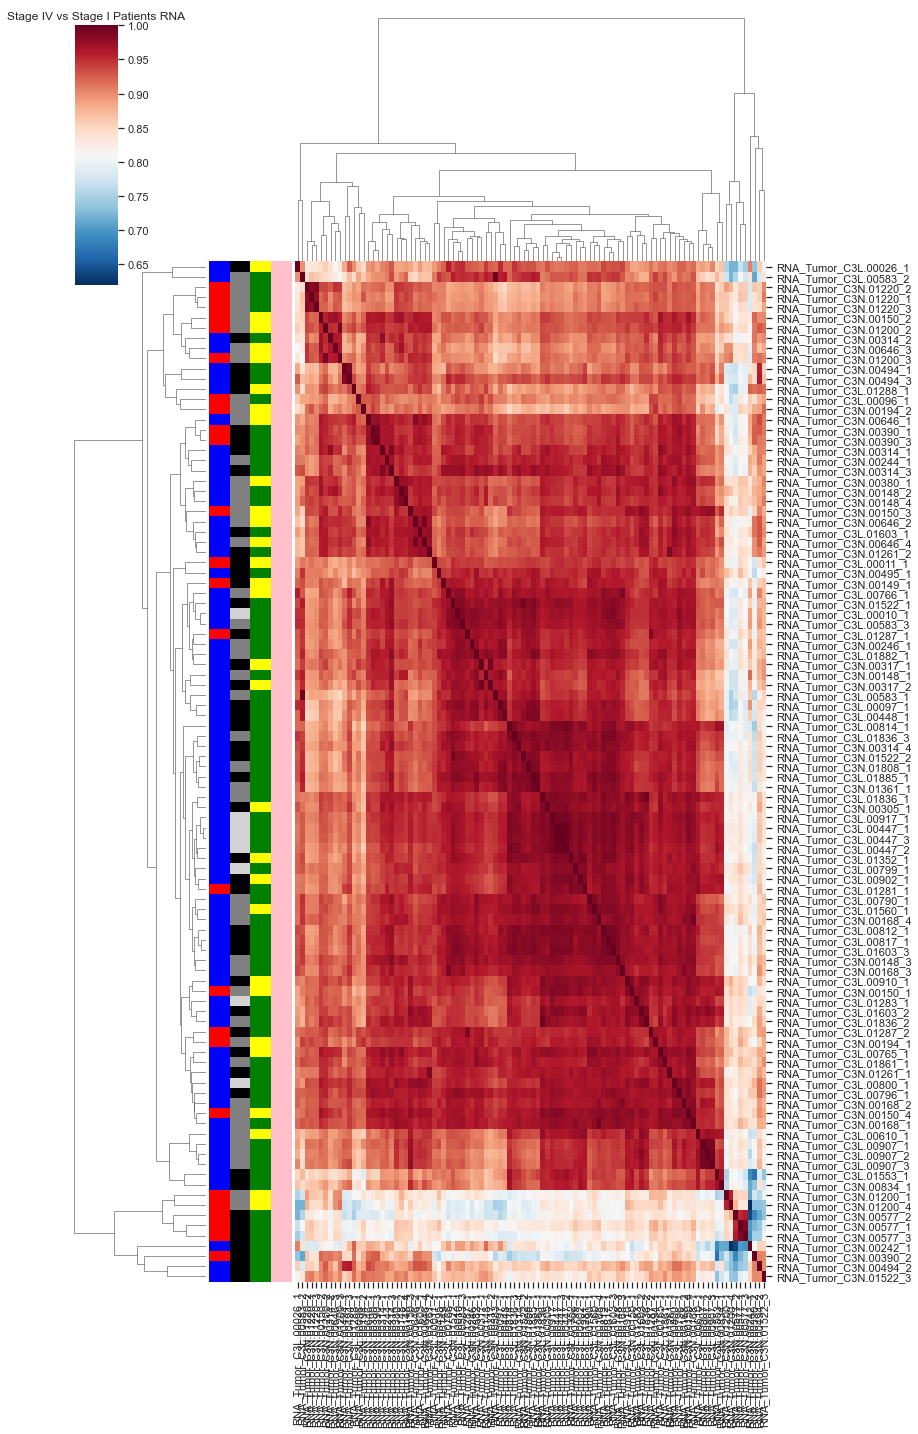

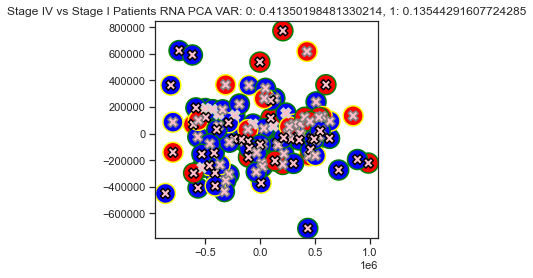

In [38]:

# Redo Methylation to remove the outlier patients
meta_cols = [c for c in rna_df.columns if 'RNA' not in c]

rna_sub_sample_df = rna_sample_df[rna_sample_df['TumorStage'].isin(['Stage IV', 'Stage I'])]
# only include tumour samples
rna_sub_sample_df = rna_sub_sample_df[rna_sub_sample_df['CondId'] == 1]
# Updated condition ID to be 1 if stage IV and 0 if stage I
rna_sub_sample_df['CondId'] = [1 if s == 'Stage IV' else 0 for s in rna_sub_sample_df['TumorStage'].values]

rna_data_df = rna_df[meta_cols + list(rna_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in rna_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in rna_data_df.columns if 'Tumor' in c]

print("RNA", len(normal_cases), len(tumour_cases))
rna_sub_sample_df.to_csv(os.path.join(output_dir, f'rna_sample_data_{test_title}_sircle.csv'))
rna_data_df.to_csv(os.path.join(output_dir, f'rna_data_{test_title}_sircle.csv'), index=False)
do_plts(rna_data_df, rna_sub_sample_df, f'{test_title} Patients RNA', fig_dir, value="RNA")


RNA 0 60


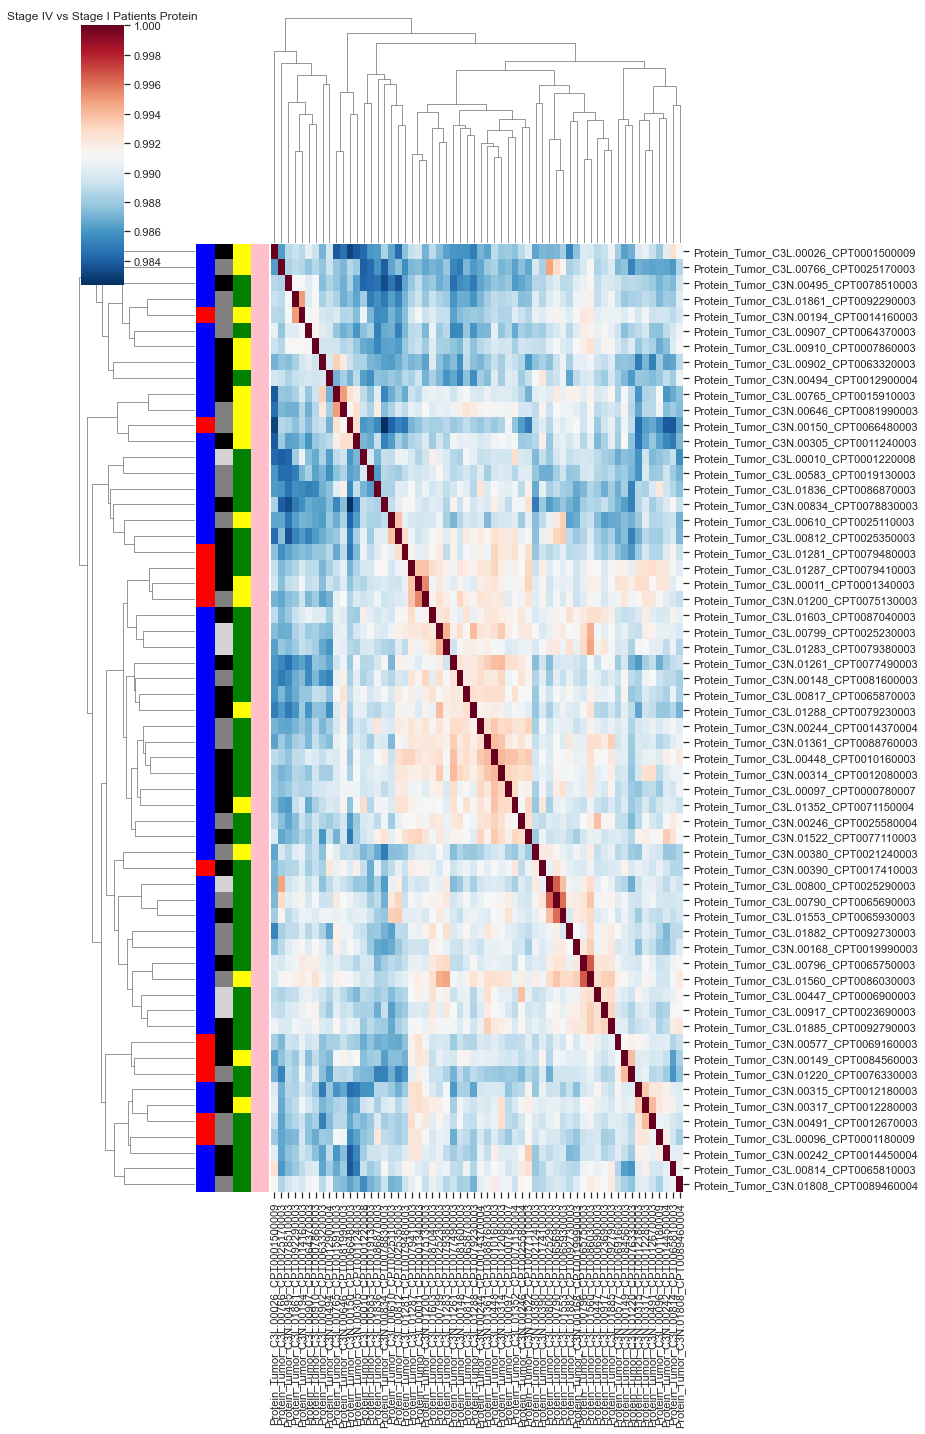

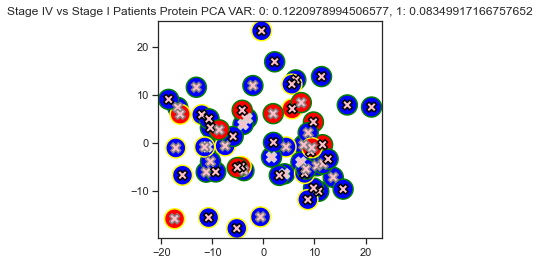

In [41]:

# Redo Methylation to remove the outlier patients
meta_cols = [c for c in prot_df.columns if 'Protein' not in c]

prot_sub_sample_df = prot_sample_df[prot_sample_df['TumorStage'].isin(['Stage IV', 'Stage I'])]
# only include tumour samples
prot_sub_sample_df = prot_sub_sample_df[prot_sub_sample_df['CondId'] == 1]
# Updated condition ID to be 1 if stage IV and 0 if stage I
prot_sub_sample_df['CondId'] = [1 if s == 'Stage IV' else 0 for s in prot_sub_sample_df['TumorStage'].values]

prot_data_df = prot_df[meta_cols + list(prot_sub_sample_df['FullLabel'].values)]

normal_cases = [c.split('_')[2] for c in prot_data_df.columns if 'Normal' in c]
tumour_cases = [c.split('_')[2] for c in prot_data_df.columns if 'Tumor' in c]

print("RNA", len(normal_cases), len(tumour_cases))
prot_sub_sample_df.to_csv(os.path.join(output_dir, f'prot_sample_data_{test_title}_sircle.csv'))
prot_data_df.to_csv(os.path.join(output_dir, f'prot_data_{test_title}_sircle.csv'), index=False)
do_plts(prot_data_df, prot_sub_sample_df, f'{test_title} Patients Protein', fig_dir, value="Protein")


## Merge all clinical information for patients from TCGA and CPTAC

In [5]:
# Save to csv file
cptac_clin_df = pd.read_csv(f'{output_dir}clinical_sircle_13052022.csv')
tcga_clin_df = pd.read_csv(f'{output_dir}clinical_TCGA_13052022.csv')
tcga_cptac_clin = cptac_clin_df.append(tcga_clin_df)
stages = []
for stage in tcga_cptac_clin['TumorStage'].values:
    if stage == 'Stage I' or stage == 'Stage II':
        stages.append('Early')
    elif stage == 'Stage III' or stage == 'Stage IV':
        stages.append('Late')
    else:
        stages.append(None)
tcga_cptac_clin['Stage'] = stages
# Make a new column which is comparing BAP1 vs PBRM1 mutations
mutation_combined = []
bap1 = tcga_cptac_clin['BAP1_mutation'].values
for i, pbrm1 in enumerate(tcga_cptac_clin['PBRM1_mutation'].values):
    if bap1[i] == 1 and pbrm1 == 0:
        mutation_combined.append('BAP1')
    elif  bap1[i] == 0 and pbrm1 == 1:
        mutation_combined.append('PBRM1')
    else:
        mutation_combined.append(None)
        
tcga_cptac_clin['BAP1&PBRM1'] = mutation_combined
print(len(tcga_cptac_clin[tcga_cptac_clin['BAP1&PBRM1'] == 'PBRM1']), len(tcga_cptac_clin[tcga_cptac_clin['BAP1&PBRM1'] == 'BAP1']))
tcga_cptac_clin.to_csv(f'{output_dir}clinical_CPTAC_TCGA.csv', index=False)
clin_df = tcga_cptac_clin

88 23


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_3112/3916815873.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tcga_cptac_clin = cptac_clin_df.append(tcga_clin_df)


## Do PCA plots

In [9]:
import matplotlib.pyplot as plt
case_to_stage = dict(zip(clin_df.SafeCases, clin_df.TumorStage))
case_to_age = dict(zip(clin_df.SafeCases, clin_df.AgeGrouped))
case_to_mutation = dict(zip(clin_df.SafeCases, clin_df['BAP1&PBRM1'].values))
opts = {'title_font_weight': 'bold', "title_font_size":9, "label_font_size":7, "figsize": (1.5, 1.5),
        "s": 50, 'opacity': 0.5}

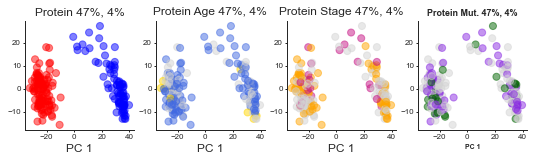

In [12]:
#Protein 
## Do some PCA plots just for QC
from sklearn.decomposition import PCA
from sciviso import Scatterplot

title = 'Protein'
df = prot_df
cols = [c for c in df.columns if title in c]
plt.rcParams["figure.figsize"] = (9, 2)

fig_size = (2, 2)
vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

age_colours = {'young': 'gold', 'old': 'royalblue'}
mut_colours = {'BAP1': 'darkgreen', 'PBRM1': 'blueviolet'}
stage_colours = {'Stage I': 'orange', 'Stage IV': 'mediumvioletred'}
tvn_colours = {'Tumor': 'red', 'Normal': 'blue'}


age_colours = [age_colours.get(case_to_age[c.split('_')[2]]) for c in cols]
stage_colours = [stage_colours.get(case_to_stage[c.split('_')[2]]) for c in cols]
mut_colours = [mut_colours.get(case_to_mutation[c.split('_')[2]]) for c in cols]
tvn_colours = [tvn_colours.get(c.split('_')[1]) for c in cols]

colours = [tvn_colours, age_colours, stage_colours, mut_colours]
fig, ax = plt.subplots(nrows=1, ncols=4)
for i, title in enumerate([f'{title}', f'{title} Age', f'{title} Stage', f'{title} Mut.']):
    colour = colours[i]
    colour = [c if c is not None else 'lightgrey' for c in colour]
    vals = df[[cols[j] for j, c in enumerate(colour)]].values.T
    colour = [colour[j] for j, c in enumerate(colour)]
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_
    vis_df = pd.DataFrame()
    vis_df['PC 1'] = pca_values[:, 0]
    vis_df['PC 2'] = pca_values[:, 1]
    sc = Scatterplot(vis_df, x = 'PC 1', y = 'PC 2',
                     colour = colour,
                     s=50, config=opts)

    sc.axis_line_width = 1.0
    sc.plot(ax=ax[i])
    # Select some colours 
    ax[i].title.set_text(f'{title} {int(100 * var_ratio[0])}%, {int(100 * var_ratio[1])}%')
    ax[i].set(xlabel='PC 1')
    #ax[i].set(ylabel='PC 2')
    
if save_fig:
    plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))
plt.show()

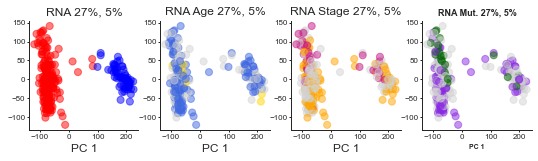

In [18]:
title = 'RNA'
import numpy as np
df = rna_df
cols = [c for c in df.columns if title in c]
plt.rcParams["figure.figsize"] = (9, 2)

fig_size = (2, 2)
vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

age_colours = {'young': 'gold', 'old': 'royalblue'}
mut_colours = {'BAP1': 'darkgreen', 'PBRM1': 'blueviolet'}
stage_colours = {'Stage I': 'orange', 'Stage IV': 'mediumvioletred'}
tvn_colours = {'Tumor': 'red', 'Normal': 'blue'}


age_colours = [age_colours.get(case_to_age[c.split('_')[2]]) for c in cols]
stage_colours = [stage_colours.get(case_to_stage[c.split('_')[2]]) for c in cols]
mut_colours = [mut_colours.get(case_to_mutation[c.split('_')[2]]) for c in cols]
tvn_colours = [tvn_colours.get(c.split('_')[1]) for c in cols]

colours = [tvn_colours, age_colours, stage_colours, mut_colours]
fig, ax = plt.subplots(nrows=1, ncols=4)
for i, title in enumerate([f'{title}', f'{title} Age', f'{title} Stage', f'{title} Mut.']):
    colour = colours[i]
    colour = [c if c is not None else 'lightgrey' for c in colour]

    vals = df[[cols[j] for j, c in enumerate(colour) if c is not None]].values.T
    # Log2 norm 
    vals = np.log2(vals + 1)
    colour = [colour[j] for j, c in enumerate(colour) if c is not None]
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_
    vis_df = pd.DataFrame()
    vis_df['PC 1'] = pca_values[:, 0]
    vis_df['PC 2'] = pca_values[:, 1]
    sc = Scatterplot(vis_df, x = 'PC 1', y = 'PC 2',
                     colour = colour,
                     s=50, config=opts)

    sc.axis_line_width = 1.0
    sc.plot(ax=ax[i])
    # Select some colours 
    ax[i].title.set_text(f'{title} {int(100 * var_ratio[0])}%, {int(100 * var_ratio[1])}%')
    ax[i].set(xlabel='PC 1')
    #ax[i].set(ylabel='PC 2')
if save_fig:
    plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))
plt.show()

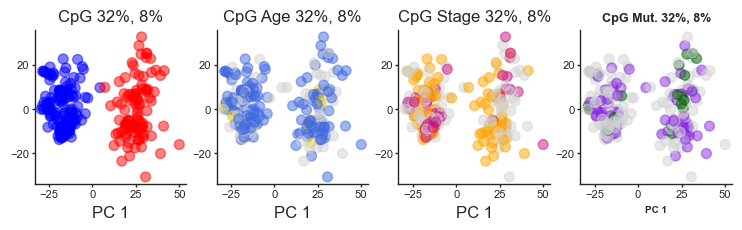

In [34]:
title = 'CpG'
df = meth_df
cols = [c for c in df.columns if title in c and 'diff' not in c]
plt.rcParams["figure.figsize"] = (9, 2)

fig_size = (2, 2)
vis_opts = {"figsize": fig_size, "title_font_size": 12, "axis_font_size": 10, 
           'palette': ['lightgrey', 'dimgrey']}

age_colours = {'young': 'gold', 'old': 'royalblue'}
mut_colours = {'BAP1': 'darkgreen', 'PBRM1': 'blueviolet'}
stage_colours = {'Stage I': 'orange', 'Stage IV': 'mediumvioletred'}
tvn_colours = {'Tumor': 'red', 'Normal': 'blue'}


age_colours = [age_colours.get(case_to_age[c.split('_')[2]]) for c in cols]
stage_colours = [stage_colours.get(case_to_stage[c.split('_')[2]]) for c in cols]
mut_colours = [mut_colours.get(case_to_mutation[c.split('_')[2]]) for c in cols]
tvn_colours = [tvn_colours.get(c.split('_')[1]) for c in cols]

colours = [tvn_colours, age_colours, stage_colours, mut_colours]
fig, ax = plt.subplots(nrows=1, ncols=4)
for i, title in enumerate([f'{title}', f'{title} Age', f'{title} Stage', f'{title} Mut.']):
    colour = colours[i]
    colour = [c if c is not None else 'lightgrey' for c in colour]
    vals = df[[cols[j] for j, c in enumerate(colour) if c is not None]].values.T
    colour = [colour[j] for j, c in enumerate(colour) if c is not None]
    pca = PCA(n_components=2)
    pca_values = pca.fit_transform(vals)
    var_ratio = pca.fit(vals).explained_variance_ratio_
    vis_df = pd.DataFrame()
    vis_df['PC 1'] = pca_values[:, 0]
    vis_df['PC 2'] = pca_values[:, 1]
    sc = Scatterplot(vis_df, x = 'PC 1', y = 'PC 2',
                     colour = colour,
                     s=50, config=opts)

    sc.axis_line_width = 1.0
    sc.plot(ax=ax[i])
    # Select some colours 
    ax[i].title.set_text(f'{title} {int(100 * var_ratio[0])}%, {int(100 * var_ratio[1])}%')
    ax[i].set(xlabel='PC 1')
    #ax[i].set(ylabel='PC 2')
plt.savefig(os.path.join(fig_dir, f'PCA_{title}.svg'))
plt.show()